In [1]:
!pip3 install psycopg2
!pip3 install flask
!pip3 install seaborn
!pip3 install descartes

     |████████████████████████████████| 380 kB 923 kB/s eta 0:00:01
  Created wheel for psycopg2: filename=psycopg2-2.8.5-cp36-cp36m-linux_x86_64.whl size=422432 sha256=998e3d7ba77f1f632402171bfeac9c072b8446d8f5a77ec3fc6ff33d76b2c0a0
  Stored in directory: /root/.cache/pip/wheels/52/9a/ab/22a0d1dc560ad5c0d09cc1c968015f89726e7e01c190dee110
Successfully built psycopg2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 94 kB 1.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 215 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import helper
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shapely
from shapely import wkt
import geopandas as gpd

In [30]:
def get_house_attributes():
    query = """SELECT 
               bouwjaar as year,
               ST_Area(ST_Force2D(geom)) as footprint_area,
               "roof_0.95" as height
               from bag3d"""
    return helper.execute_query(query)
def get_region_house_attributes(regioncode):
    query = """SELECT 
               bouwjaar as year,
               ST_Area(ST_Force2D(geom)) as footprint_area,
               "roof_0.95" as height
               from bag3d
               where gemeentecode='{}' """.format(regioncode)
    return helper.execute_query(query)
@helper.maybe
def year_from_datetime(datetime):
    return datetime.year
@helper.maybe
def filter_logical(year):
    return year if year<2021 else None
@helper.maybe
def volume(area, height):
    return area*height
def calculate_year_and_volume(res):
    return filter_logical(year_from_datetime(res[0])), volume(res[1],res[2])

In [4]:
years_and_volumes = [calculate_year_and_volume(i)
                     for i in get_house_attributes()]

In [31]:
groningen_years_and_volumes = [calculate_year_and_volume(i)
                     for i in get_region_house_attributes("0014")]

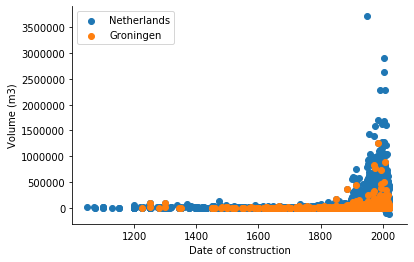

In [36]:
fig,ax = plt.subplots(1)
ax.scatter([i[0] for i in years_and_volumes],
           [i[1] for i in years_and_volumes], label='Netherlands')
ax.scatter([i[0] for i in groningen_years_and_volumes],
           [i[1] for i in groningen_years_and_volumes], label='Groningen')
ax.set_ylabel('Volume (m3)')
ax.set_xlabel('Date of construction')
ax.legend()
sns.despine()

### Data format
 ogc_fid                     | integer                  |  
 
 identificatie               | character varying(16)    |  
 
 aanduidingrecordinactief    | boolean                  |  
 
 aanduidingrecordcorrectie   | integer                  |  
 
 officieel                   | boolean                  |  
 
 inonderzoek                 | boolean                  |  
 
 documentnummer              | character varying(20)    | 
 
 documentdatum               | date                     | 
 
 bouwjaar                    | date                     | 
 
 begindatumtijdvakgeldigheid | timestamp with time zone |
 
 einddatumtijdvakgeldigheid  | timestamp with time zone | 
 
 gemeentecode                | character varying(4)     | 
 
 ground_0.00                 | real                     | 
 
 ground_0.10                 | real                     | 
 
 ground_0.20                 | real                     | 
 
 ground_0.30                 | real                     | 
 
 ground_0.40                 | real                     | 
 
 ground_0.50                 | real                     | 
 
 roof_0.25                   | real                     | 
 
 rmse_0.25                   | real                     | 
 
 roof_0.50                   | real                     | 
 
 rmse_0.50                   | real                     | 
 
 roof_0.75                   | real                     | 
 
 rmse_0.75                   | real                     | 
 
 roof_0.90                   | real                     | 
 
 rmse_0.90                   | real                     | 
 
 roof_0.95                   | real                     | 
 
 rmse_0.95                   | real                     | 
 
 roof_0.99                   | real                     | 
 
 rmse_0.99                   | real                     | 
 
 roof_flat                   | boolean                  | 
 
 nr_ground_pts               | integer                  | 
 
 nr_roof_pts                 | integer                  | 
 
 ahn_file_date               | timestamp with time zone | 
 
 ahn_version                 | smallint                 | 
 
 height_valid                | boolean                  | 
 
 tile_id                     | character varying        | 
 
 geom                        | geometry(PolygonZ,28992) |
 

### Example geometry

In [25]:
def get_some_shapes():
    q = """SELECT ST_AsText(ST_Force2d(ST_Transform(bag.geom,4326))) from bag3d bag
           WHERE bag.gemeentecode='0014';"""
    spatialq = """SELECT ST_AsText(ST_Force2d(ST_Transform(bag.geom,4326)))
                  from bag3d bag
                  LEFT JOIN netherlandsregions nr
                  on ST_Within(ST_Force2d(ST_Transform(bag.geom,4326)),
                               nr.wkb_geometry);"""
    return [i[0] for i in helper.execute_query(q)]
def convert_to_shapes(i):
    return wkt.loads(i)

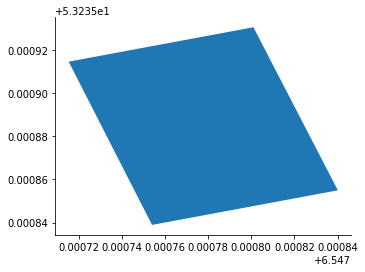

In [26]:
shapes = gpd.GeoDataFrame([convert_to_shapes(i) for i in get_some_shapes()],columns=['geometry'])
ax = shapes[0:1].plot()
sns.despine()

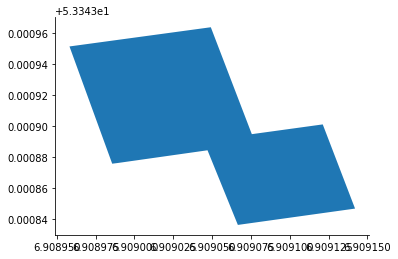

In [18]:
ax2 = shapes[1:2].plot()
sns.despine()

In [27]:
shapes.to_file("groningenbag.json", driver="GeoJSON")

### Two ideas for clustering
#### Goal - we want a clustering algorithm which is translation and rotation invariant, but sensitive to scale
1) Use Hausdorff distance to create similarity matrix -see Joshi, D., Samal, A. K., & Soh, L. K. (2009, March). Density-based clustering of polygons. In 2009 IEEE symposium on computational intelligence and data mining (pp. 171-178). IEEE.  
2) Convert polygon to 1d representation using distance from centroid and then use time series clustering -see Yankov, D., & Keogh, E. (2006, December). Manifold clustering of shapes. In Sixth International Conference on Data Mining (ICDM'06) (pp. 1167-1171). IEEE.

In [122]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return 1000* c * r #in metres

def polygon_to_timeseries(polygon):
    centroidx,centroidy = polygon.centroid.xy
    centroid = list(zip(centroidx, centroidy))[0]
    pointsx, pointsy = polygon.exterior.coords.xy
    pointlist = list(zip(pointsx, pointsy))
    return [haversine(*point, *centroid) for point in pointlist ]

In [123]:
shapes['timeseries'] = shapes['geometry'].apply(polygon_to_timeseries)

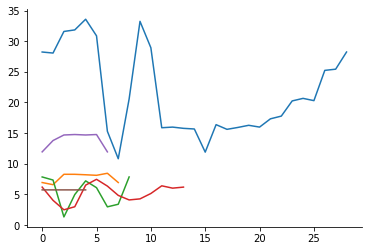

In [114]:
fig,ax = plt.subplots(1)
for idx,ts in enumerate(shapes.iloc[150:156]['timeseries']):
    ax.plot(ts, label=idx+150)
sns.despine()

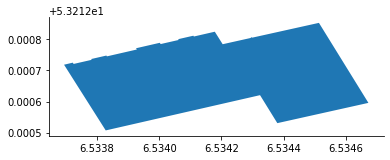

In [118]:
ax=shapes.iloc[150:151].plot()
sns.despine()

### Needs to be consistently re-meshed so every polygon has an equal number of points
